In [1]:
from torchvision import utils
from data_loader import *
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch
import time
import pickle as pkl
import vocabulary_struct
import AnnoNet
#import AnnoNetRNN as AnnoNet
import csv
import numpy as np
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from matplotlib import pyplot as plt
from PIL import Image
import json

In [2]:
from tqdm import tqdm, tqdm_notebook
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import numpy as np
from pycocotools.coco import COCO

In [3]:
model_path = "best_model_base3.pt"
train_loss_path = "train_loss_base3"
val_loss_path = "val_losses_base3"

prediction = 's'
temp = 0.1 # 0.2 is best

true_annotations_file ='./data/annotations/captions_val2014.json'
pred_annotations_file = 'stoch_0_1_model_captions.json'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
with open('Vocab_File', 'rb') as f:
    vocab = pkl.load(f)

with open('TestImageIds.csv', 'r') as f:
    reader = csv.reader(f)
    testIds = list(reader)

testIds = [int(i) for i in testIds[0]]

In [6]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        #torch.nn.init.xavier_uniform_(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)
        
epochs     = 100
batch_size = 128
criterion = torch.nn.CrossEntropyLoss()
AnnoNet = AnnoNet.AnnoNet(vocab_size = len(vocab), batch_size = batch_size, embedding_dim=256,hidden_dim = 512, hidden_units=1)
AnnoNet.apply(init_weights)
AnnoNet.load_state_dict(torch.load(model_path))
AnnoNet.eval()

AnnoNet.to(device)

AnnoNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [7]:
test_coco = CocoDataset(root='./data/images/test/',
                       json='./data/annotations/captions_val2014.json',
                       ids = testIds,
                       vocab=vocab,
                       transform=None)

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


In [8]:
transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

def prep_image(image, transform=None):
    image = image.resize([250, 250], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

['<start>', 'an', 'elephant', 'playing', 'with', 'water', 'at', 'a', 'watering', 'hole', 'with', 'his', 'trunk', '<end>']


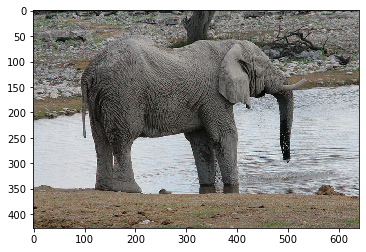

In [9]:
test_idx = 0
prediction = 's'
temp = 0.2 # best temperature for stochastic

test_im, test_tar = test_coco.__getitem__(test_idx)
plt.imshow(test_im)

sentence = []
for i in test_tar:
    #print(i)
    word = vocab.index2word[int(i)]
    sentence.append(word)
    
print(sentence)

In [10]:
new_test_im = prep_image(test_im, transform)
new_test_im = new_test_im.to(device)

new_test_output = AnnoNet.eval_pass(new_test_im, prediction=prediction, temp=temp)
my_out = new_test_output[0].cpu()

out_sentence = []
for i in my_out:
    #print(i)
    word = vocab.index2word[int(i)]
    out_sentence.append(word)
    
print(out_sentence)

['<start>', 'an', 'elephant', 'walking', 'in', 'the', 'water', 'next', 'to', 'a', 'river', '.', '<end>']
